In [143]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from scipy.special import expit
from scipy.optimize import fmin, minimize
import glob as glob
import matplotlib
matplotlib.style.use('ggplot')

# .py
%load_ext autoreload
%autoreload 2
import weather_alphas, weather_costs, model, model_01

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
running model


In [51]:
def split_data(data):
    train_mask = (data.index < "2011")
    train = data[train_mask]
    test_mask = (data.index > "2011")
    test = data[test_mask]
    return train, test

### Retrieve Weather Data

In [52]:
all_weather = pd.read_csv("weather01-16.csv")

In [53]:
cm_weather = all_weather[all_weather.stn_name == "Chiang Mai"]
cm_weather.index = pd.DatetimeIndex(cm_weather.date)
mask = (cm_weather.index > "2003") & (cm_weather.index < "2016")
cm_weather = cm_weather[mask]

provinces_df = pd.read_csv("all-dengues.csv")
provinces_df.index = pd.DatetimeIndex(provinces_df.date)
provinces_df = provinces_df.drop(['date','date.1'],axis=1)
cm_dengues = provinces_df[provinces_df['จังหวัด'] == 'ChiangMai'].resample('W').size()
cm_dengues_df = pd.DataFrame(cm_dengues,columns=['cases'])

### Weather Data is only available til Aug of 2016 so use the data til end of 2015. Therefore, dengue data as well

In [54]:
cm_avg_weather = cm_weather[['avgrh','dday','meantemp']].resample('W').mean()
cm_avg_weather['rain'] = cm_weather[['rain']].resample('W').sum() # cumulative rainfall
cm_dengues_weather = pd.concat([cm_avg_weather,cm_dengues_df[:-52]],axis=1)

cm_dengues_weather_split = split_data(cm_dengues_weather)
cm_dengues_train, cm_dengues_test = cm_dengues_weather_split[0], cm_dengues_weather_split[1]

In [55]:
cm_dengues_weather.iloc[:30,:]

,avgrh,dday,meantemp,rain,cases
date,,,,,
2003-01-05,88.250000,3.500000,23.500000,12.2,1
2003-01-12,81.000000,9.000000,22.828571,0.0,2
2003-01-19,80.714286,16.000000,21.457143,0.0,5
2003-01-26,75.857143,23.000000,20.671429,0.0,0
2003-02-02,75.857143,21.142857,22.628571,0.0,2
2003-02-09,74.857143,6.000000,22.728571,0.0,2
2003-02-16,70.857143,13.000000,24.957143,0.0,1
2003-02-23,62.857143,20.000000,24.200000,0.0,4
2003-03-02,57.857143,19.000000,24.457143,0.0,3


In [56]:
def make_line(start_week,real,predictions,title,x_axis,y_axis,
              real_legend='Real',predict_legend='Prediction'):
    plt.figure(figsize=(12,6))
    plt.plot(range(len(real)),real,'-r',label=real_legend)
    plt.plot(range(start_week,len(predictions)+start_week),predictions,'-k',label=predict_legend,alpha=0.4)
    plt.axvline(start_week)
    plt.text((start_week*2)+10,300,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.legend()
    plt.title(title)
    
def plot_all_predictions(LAG, real, province, nweeks_to_predict, all_predictions):
    
    plt.figure(figsize=(13,6))
    plt.plot(range(len(real)),real,label='real')
    graph_title = "%s's Dengue Prediction with Mean Temperature"%province
    plt.title(graph_title)
    for i in range(len(all_predictions)):
        cur_week_guess = nweeks_to_predict[i]
        start_predict_week = LAG+(cur_week_guess-1)
        predicted_cases = all_predictions[i]
        x_weeks = range(start_predict_week,len(predicted_cases)+start_predict_week)
        line_label = "%d week guess"%cur_week_guess
        plt.plot(x_weeks,predicted_cases,label=line_label,alpha=0.8)
    
    seperate_train_test(cm_dengues_df.cases,cm_dengues_train)
    plt.axvline(LAG)
    plt.text((LAG*2)+10,300,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel("# week starting 2003")
    plt.ylabel("Dengue cases")
    plt.legend()
    plt.savefig("16-lags-16-weeks-9-temp-wks-chiangmai-00.png")
    
def seperate_train_test(all_data,train_data):
    plt.axvspan(0, len(train_data), color='blue', alpha=0.1)
    plt.text((len(train_data)/2)-25,700,'Train Period',size=16)
    plt.axvline(len(train_data)+1,linewidth=0.5, color='green')
    plt.text(len(train_data)+20,700,'Test Period',size=16)
    plt.axvspan(len(train_data)+1, len(all_data), color='green', alpha=0.1)

In [169]:
%%time
cm_16_add = weather_alphas.get_alphas(16,9,10,cm_dengues_train[:52])

running model
40
40
all_arr
CPU times: user 9min 37s, sys: 2.85 s, total: 9min 40s
Wall time: 9min 45s


In [194]:
cm_16_add.x

array([  3.97284561e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   2.72505353e-03,
         5.73356709e-01,   3.09066490e-08,  -2.85698561e-01,
         1.17162353e+01,   1.19903511e+00,   7.95786250e-01,
        -2.84456617e+00,  -2.02639839e-02,  -1.36805038e+00,
        -1.04083751e+00,   1.79087865e+00,   1.54163938e+00,
         3.25631527e-01,   1.36912475e+00,  -1.45416367e-01,
         3.18550885e-02,   6.13823486e-03,  -3.86416227e-03,
        -3.22073410e-03,   2.48589139e-03,  -4.13651139e-02,
         5.25938855e-02,  -4.76866453e-02,  -1.03947843e-02,
         6.82901137e-04])

In [81]:
%%time
cm_16_add_full = weather_alphas.get_alphas(16,9,10,cm_dengues_train)

40
40
all_arr
CPU times: user 2h 59min 29s, sys: 1min 27s, total: 3h 56s
Wall time: 3h 4min 35s


In [188]:
cm_16_add_full

      fun: 298.77094579510555
 hess_inv: <40x40 LbfgsInvHessProduct with dtype=float64>
      jac: array([  3.02869125e+00,  -1.18689059e-02,  -4.78053153e-03,
        -3.00133252e-03,  -3.41060513e-05,  -4.54747351e-05,
         0.00000000e+00,   1.13686838e-05,   1.13686838e-05,
         5.68434189e-06,   0.00000000e+00,   0.00000000e+00,
         1.13686838e-05,   5.68434189e-06,   0.00000000e+00,
         2.22231051e+00,   4.40678605e-01,   2.12353939e+00,
         8.46431476e+00,   1.30474746e+01,  -1.94507493e+01,
        -2.34096831e+01,  -1.76001151e+01,  -2.88643605e+01,
        -2.15063778e+01,  -1.38229780e+01,  -1.76366541e+01,
        -6.20038918e+00,  -7.30829584e+00,  -4.95049335e-02,
        -7.10285804e+00,  -4.15442969e+00,  -2.29421175e+00,
         8.05425771e-01,   1.13510623e+00,   1.56508122e+00,
         3.58901957e+00,   6.57104238e-01,   4.05134415e-01,
         1.03473781e+00])
  message: 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT'
     nfev: 15006

In [84]:
# pd.DataFrame(cm_16_add_full.x).to_csv('16-lags-16-weeks-9-temp-10-rain-chiangmai-00.csv',index=False)

In [182]:
ws_csv = pd.read_csv('16-lags-16-weeks-9-temp-10-rain-chiangmai-00.csv')
aa = np.append([],np.array(ws_csv))
len(aa)

40

In [142]:
# %%time
# ws_csv_df = pd.read_csv('16-lags-16-weeks-9-temp-wks-chiangmai-00.csv')
# ws_csv = np.append([],np.array(ws_csv_df))
# cm_16 = weather_alphas.get_alphas(16,9,cm_dengues_train,ws_csv=ws_csv)

running model


In [248]:
cm_16.x

array([  9.61211813e-02,   1.72192925e-02,   1.80836212e-03,
         1.58402313e-02,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   2.97885047e-07,   1.84455325e-02,
         2.65748425e-02,   3.03515141e-02,   5.82038936e-01,
         1.09483927e+01,   1.76711845e+00,   3.97188791e-01,
        -6.38500770e-01,  -1.04255891e+00,  -1.26904683e+00,
        -6.18459499e-01,   3.93512471e-01,   2.20589571e+00,
         3.69883909e+00,   4.68217830e+00])

In [246]:
ws_csv

array([  1.02033529e-01,   2.27736006e-02,   3.90921405e-03,
         5.71538961e-03,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   1.37771680e-03,   4.44020911e-03,
         3.28166537e-02,   2.97414987e-02,   5.23939394e-01,
         1.16465605e+01,   1.55979704e+00,   2.10345037e+00,
         2.93784460e-01,  -1.34772844e+00,  -2.25757541e+00,
        -1.08141065e+00,   1.46282013e+00,   2.18522250e+00,
         3.06260276e+00,   3.52131376e+00])

In [195]:
def get_predictions(LAG, TEMPERATURE_WEEKS, RAIN_WEEKS, real, ws, province, nweeks_to_predict=[1,2,4,8,16]):

    def n_week_ahead(cases_for_prediction, temps_for_prediction, rains_for_prediction, 
                     weeks_ahead, case_week_to_predict):

        cur_prediction = 0
        prev_cases = np.array(cases_for_prediction.cases)
        for i in range(weeks_ahead):
            week_to_predict = case_week_to_predict + i
#             print week_to_predict
#             print case_week_to_predict + i
#             print case_week_to_predict
#             mean_temp = real.meantemp[]
            cur_prediction = model.guess(
                ws, 
                week_to_predict, 
                prev_cases,
                temps_for_prediction,
                rains_for_prediction)
            prev_cases = np.append(prev_cases[1:],cur_prediction) # deduct the first elm out
        return cur_prediction

    all_predictions = []
    for nweek in nweeks_to_predict: # 1,2,4,8,16
        predictions = []
        for start_week in range(len(real)-(LAG)):
            case_week_to_predict = start_week + LAG
            cases_for_prediction = real[start_week:case_week_to_predict]
            
            temp_week_to_predict = start_week+TEMPERATURE_WEEKS
            temps_for_prediction = real.meantemp[start_week:temp_week_to_predict]
            
            rain_week_to_predict = start_week+RAIN_WEEKS
            rains_for_prediction = real.meantemp[start_week:rain_week_to_predict]
            
            prediction = n_week_ahead(
                cases_for_prediction,
                temps_for_prediction,
                rains_for_prediction,
                nweek,
                case_week_to_predict)
            predictions.append(prediction)
        all_predictions.append(predictions)
    return all_predictions

    ## plot all predictions
#     plot_all_predictions(LAG, real.cases, province, nweeks_to_predict, all_predictions)
    
def validation(prediction, real):
    residual_sq = (real - prediction)**2
    real = np.array(real)
    sigma = np.mean(real)**0.5
    score = residual_sq / float(sigma)
    return sum(score) / len(real)

In [196]:
for_validation_01 = get_predictions(16, 9, 10, cm_dengues_weather, cm_16_add_full.x, "ChiangMai")

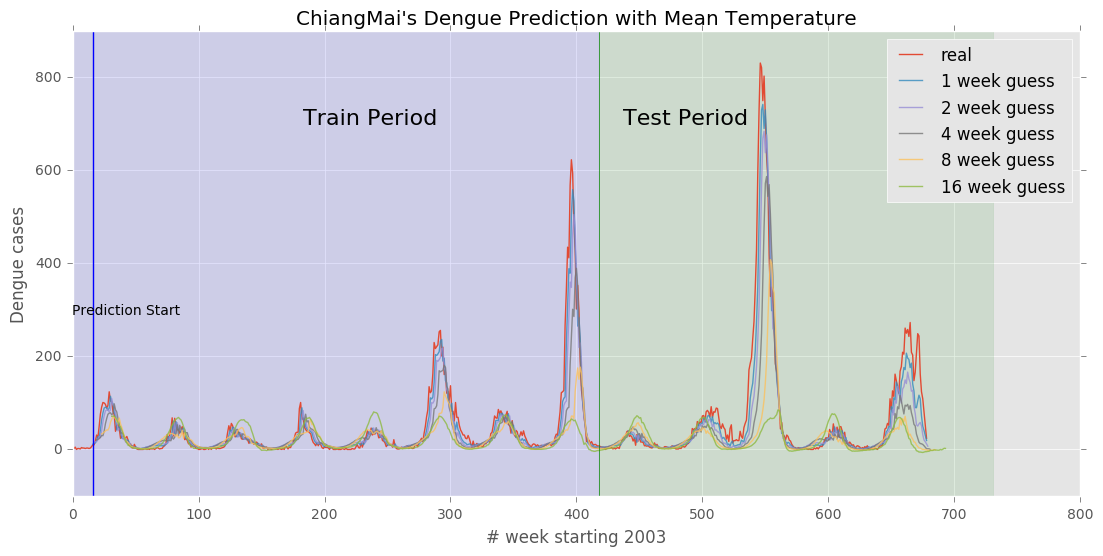

In [201]:
plot_all_predictions(16, cm_dengues_weather.cases, "ChiangMai", [1,2,4,8,16], for_validation_01)

In [197]:
a = [1,2,4,8,16]
for i,e in enumerate(for_validation_01):
    pred = np.array(e)
#     print len(pred[:-a[i]])
#     print len(cm_dengues_weather.cases[16+a[i]:])
    print validation(pred[:-a[i]],cm_dengues_weather.cases[16+a[i]:])
    
#     plt.plot(range(len(cm_dengues_weather.cases[16+a[i]:])),cm_dengues_weather.cases[16+a[i]:])
#     plt.plot(pred[:-a[i]])
#     cm_dengues_weather.cases[16+a[i] - 1:] - pred[:a[i]-1]

241.594110209
450.157199276
880.334553184
1457.13772329
1693.57336387


In [191]:
a = [1,2,4,8,16]
for i,e in enumerate(for_validation_02):
    pred = np.array(e)
#     print len(pred[:-a[i]])
#     print len(cm_dengues_weather.cases[16+a[i]:])
    print validation(pred[:-a[i]],cm_dengues_weather.cases[16+a[i]:])

241.59411021
450.157199277
880.334553186
1457.1377233
1693.57336387


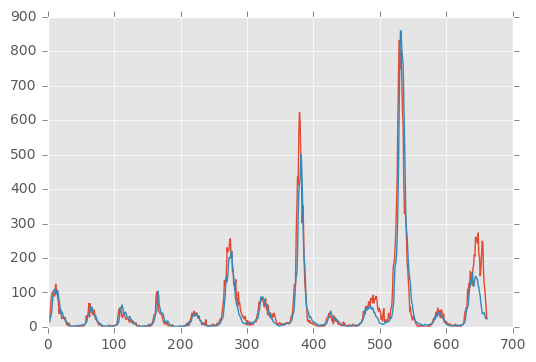

In [187]:
# plt.plot(range(len(cm_dengues_weather.cases[16+1:])),cm_dengues_weather.cases[16+1:])
plt.plot(for_validation[0][:-1])


In [193]:
def validation(prediction, real):
    residual_sq = (real - prediction)**2
    real = np.array(real)
    sigma = np.mean(real)**0.5
    score = residual_sq / float(sigma)
    return sum(score) / len(real)

validation(for_validation[0][:-1],cm_dengues_weather.cases[16+1:])

235.68935928683646

In [ ]:
## 

In [68]:
def nweek_ahead_cost(ws, week_forward, start_week, end_week, data, cases_for_pred, temps_for_pred):
    
#     print end_week
    ret = 0
    for aweek in range(week_forward): # 16 loops; when you want to predict 14 weeks ahead
        week_to_predict = aweek+end_week
        real_case = data.cases[aweek+end_week] +1 # avoid getting zeros
        
#         print "real",real_case - 1
#         print "mean_temp",mean_temperatures
#         print 'wtp',week_to_predict
#         print cases_for_pred
#         print "tmp_week",aweek,end_temp_wk
#         print "end_week",aweek,end_week
    
        predicted_case = model.guess(
              ws, 
              week_to_predict, 
              cases_for_pred,
              temps_for_pred,
              )
        
        cases_for_pred = np.append(cases_for_pred[1:],predicted_case)
        sigma_sq = real_case + 1
        ret += ((real_case - predicted_case)**2)/float(sigma_sq)
    return ret
    
    
data = cm_dengues_train[:42] #range(1,100)
start_week,end_week,end_temp_wk = 0,16,9
week_forward = 16

all_penalties = []
for real_week in range(len(data)-(week_forward+end_week-1)):
    cases_for_pred = data.cases[start_week:end_week]
    temps_for_pred = data.meantemp[start_week:end_temp_wk]
#     mean_temp = data.meantemp[]
#     print len(cases_for_pred)
#     print 'fw',future_week
#     print "meantemp", data.meantemp[real_week]
    print temps_for_pred
    cur_penalty = nweek_ahead_cost(
        [1.]*29, 
        week_forward, 
        start_week, 
        end_week, 
        data,
        cases_for_pred,
        temps_for_pred)
    
    all_penalties.append(cur_penalty)
        
    start_week+=1
    end_week+=1
    end_temp_wk+=1

# all_penalties

date
2003-01-05    23.500000
2003-01-12    22.828571
2003-01-19    21.457143
2003-01-26    20.671429
2003-02-02    22.628571
2003-02-09    22.728571
2003-02-16    24.957143
2003-02-23    24.200000
2003-03-02    24.457143
Freq: W-SUN, Name: meantemp, dtype: float64
date
2003-01-12    22.828571
2003-01-19    21.457143
2003-01-26    20.671429
2003-02-02    22.628571
2003-02-09    22.728571
2003-02-16    24.957143
2003-02-23    24.200000
2003-03-02    24.457143
2003-03-09    25.828571
Freq: W-SUN, Name: meantemp, dtype: float64
date
2003-01-19    21.457143
2003-01-26    20.671429
2003-02-02    22.628571
2003-02-09    22.728571
2003-02-16    24.957143
2003-02-23    24.200000
2003-03-02    24.457143
2003-03-09    25.828571
2003-03-16    26.414286
Freq: W-SUN, Name: meantemp, dtype: float64
date
2003-01-26    20.671429
2003-02-02    22.628571
2003-02-09    22.728571
2003-02-16    24.957143
2003-02-23    24.200000
2003-03-02    24.457143
2003-03-09    25.828571
2003-03-16    26.414286
2003-03-

In [23]:
bng = [(None,None),(1,None)]
[bng.extend([(None,0.)]) for i in range(5)]
bng 

[None, None, None, None, None]

In [ ]:
# def validation():
